## Yearly Smoke Impact Calculation

### Overview

The purpose of the smoke impact calculation is to quantify the annual smoke exposure for Memphis from fires within a 650-mile radius. This calculation considers both the **size of each fire** and **its distance from the city**, with larger, closer fires contributing more to the city’s smoke impact.

### Decision-Making Process

In designing the smoke impact calculation, I considered several factors to meet the assignment's requirements:

-  **Fire Size and Proximity**: Larger fires closer to the city are expected to produce more smoke exposure in Memphis. Therefore, the smoke impact score should be higher for such fires and lower for smaller, more distant fires.

-  **Amortization vs. Cumulative Impact**: Instead of simply summing each fire's impact, I chose to **amortize the smoke impact over the fire’s estimated duration**. This approach reflects how smoke impact accumulates and dissipates over the fire season, which provides a more realistic annual estimate.

- **Scaling**: To keep the annual smoke impact score within a realistic range, I applied an absolute scaling factor. This keeps most annual smoke impact scores below 50, with only the most extreme years approaching higher values.

### Calculation Methodology

The following steps outline the method used to calculate the annual smoke impact score:

#### 1. **Determine Individual Fire Impact**:
   - For each fire within a 650-mile radius, I calculated a preliminary smoke impact score.
   - This score is based on two factors:

     - **Size Factor**: The fire’s size (in acres) is normalized by the largest fire observed within the 650-mile radius, giving a score between 0 and 1.

     - **Distance Factor**: The proximity to Memphis is scaled as 
       $
       \left( 1 - \frac{\text{distance}}{\text{MAX\_DISTANCE}} \right)
       $
       so that closer fires have a higher impact score.
     
   - The smoke impact for each fire is calculated as:
     $$
     \text{smoke\_impact} = \text{size\_factor} \times \text{distance\_factor} \times 500
     $$
     This formula provides a score between 0 and 500 for each fire, with large, close fires receiving higher scores.



#### 2. **Estimate Fire Duration and Amortize Impact**:
- The **estimated duration** of each fire is determined based on its size, using a scale from 10 to 150 days:

    $$
    \text{fire\_duration} = \text{MIN\_FIRE\_DURATION} + (\text{size\_factor} \times (\text{MAX\_FIRE\_DURATION} - \text{MIN\_FIRE\_DURATION}))
    $$
     
   - Each fire's smoke impact is then **amortized** over its duration, resulting in a **daily impact** value:
     \[
     \text{amortized\_smoke\_impact} = \frac{\text{smoke\_impact}}{\text{fire\_duration}}
     \]

#### 3. **Aggregate and Scale Annual Smoke Impact**:
   - I calculated the total annual smoke impact by summing all amortized smoke impacts for fires within each year.
   - To keep yearly values within a realistic range (mostly under 50), I applied a fixed scaling factor to these yearly totals.

#### 4. **Resulting Annual Score**:
   - This annual score, named `scaled_smoke_impact`, reflects the yearly smoke impact for Memphis. The score values are generally below 50, with only the most intense fire years producing higher scores. This aligns with the expected real-world variation in yearly smoke exposure.

### Example

For a fire with 500,000 acres located 100 miles from Memphis:
1. The **size factor** would be calculated as `500000 / max_acres_within_radius`.
2. The **distance factor** would be $ \left( 1 - \frac{100}{650} \right) $.
3. The **smoke impact** is calculated by combining these factors and scaling to the 0–500 range.
4. The final annual impact score for each year is the sum of the amortized impacts, scaled to maintain consistency in values across years.


In [1]:
import json
import geojson
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_6915/3376677112.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)


FIRE_INPUT_PATH = output_paths.get('stage0_fire_json')
#FIRE_INPUT_PATH = output_paths.get('POC_stage0_fire_json')

In [3]:
SI_PER_FIRE_OUTPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
SI_PER_YEAR_OUTPUT_PATH = output_paths.get("stage1_si_per_year_csv")

In [4]:
with open(FIRE_INPUT_PATH) as fire_file:
    fire_data = geojson.load(fire_file)

In [5]:
# Function to check the number of records and ensure all have the same keys
def check_records(data, record_type="Record"):
    # Get the set of keys from the first record
    first_record_keys = set(data[0].get('attributes', {}).keys())

    # Initialize a list to collect error records and a counter for mismatches
    error_records = []
    mismatched_count = 0

    # Iterate through all records to compare the keys
    for index, feature in enumerate(data):
        current_keys = set(feature.get('attributes', {}).keys())

        # Check if the keys match with the first record's keys
        if current_keys != first_record_keys:
            mismatched_count += 1
            print(f"{record_type} {index} has a different set of keys.")
            print(f"Expected keys: {first_record_keys}")
            print(f"Found keys: {current_keys}")
            
            # Add the mismatched record to the error list
            error_records.append(feature)

    # Final report
    total_records = len(data)
    print(f"\nTotal number of {record_type.lower()}s: {total_records}")
    
    if mismatched_count == 0:
        print(f"All {record_type.lower()}s contain the same set of keys.")
    else:
        print(f"{mismatched_count} {record_type.lower()}s have mismatched keys.")

    # Return the error records if there are any mismatches
    return error_records, first_record_keys


In [6]:
# Check the fire_data and features_with_smoke_impact
print("\nChecking fire_data...")
fire_data_errors, fire_data_keys = check_records(fire_data['features'], record_type="Fire data record")

# Optional: You can save the error records for later analysis
if fire_data_errors:
    with open('fire_data_error_records.json', 'w') as fire_error_file:
        json.dump({"features": fire_data_errors}, fire_error_file, indent=4)
    print("Fire data error records have been written to 'fire_data_error_records.json'.")


Checking fire_data...

Total number of fire data records: 101906
All fire data records contain the same set of keys.


## Convert to Pandas Dataframe

In [7]:
# Extract the list of fire attributes from each feature
fire_attributes = [feature['attributes'] for feature in fire_data['features']]

# Convert the list of attributes dictionaries to a DataFrame
fire_df = pd.DataFrame(fire_attributes)

In [8]:
print(fire_df.columns)
print(f"Number of rows: {fire_df.shape[0]}")

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'distance'],
      dtype='object')
Number of rows: 101906


In [9]:
# Display the first few rows to verify the structure
print(fire_df.head())

   OBJECTID  USGS_Assigned_ID Assigned_Fire_Type  Fire_Year  \
0     14600             14600           Wildfire       1964   
1     14602             14602           Wildfire       1964   
2     14605             14605           Wildfire       1964   
3     14606             14606           Wildfire       1964   
4     14607             14607           Wildfire       1964   

   Fire_Polygon_Tier Fire_Attribute_Tiers     GIS_Acres  GIS_Hectares  \
0                  1         1 (1), 3 (3)  65338.877636  26441.705659   
1                  1         1 (2), 3 (3)  19218.105903   7777.291530   
2                  1         1 (2), 3 (4)  14101.443662   5706.651785   
3                  1         1 (2), 3 (3)  11365.328284   4599.385176   
4                  1         1 (1), 3 (1)  11131.171732   4504.625381   

                                     Source_Datasets  \
0  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
1  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
2  Comb_Nation

## Smoke Impact Calculations per Fire

In [10]:
# Constants for distance and fire duration
MIN_FIRE_DURATION = 10  # Minimum duration of a fire in days
MAX_FIRE_DURATION = 150  # Maximum duration of a fire in days
MAX_DISTANCE = 650       # Maximum distance for considering impact

# Define function for estimating fire duration based on size
def estimate_fire_duration(gis_acres, max_acres):
    normalized_size = gis_acres / max_acres
    fire_duration = MIN_FIRE_DURATION + (normalized_size * (MAX_FIRE_DURATION - MIN_FIRE_DURATION))
    return max(MIN_FIRE_DURATION, min(fire_duration, MAX_FIRE_DURATION))

# Function to calculate smoke impact for each fire
def get_smoke_impact(gis_acres, dist_from_memphis, max_acres):
    if gis_acres is None or dist_from_memphis is None:
        return 0  # Ignore fires with missing data
    
    # Calculate normalized size and distance factors
    size_factor = gis_acres / max_acres
    distance_factor = 1 - (dist_from_memphis / MAX_DISTANCE)

    # Smoke impact score for this fire
    smoke_impact = size_factor * distance_factor * 500  # Scale up to match the 0-500 range for 
    
    return max(smoke_impact, 0)

# Load and preprocess fire data
filtered_fire_df = fire_df[fire_df['distance'] <= MAX_DISTANCE]
max_acres_within_radius = filtered_fire_df['GIS_Acres'].max()

# Apply smoke impact calculation for each fire
filtered_fire_df['smoke_impact'] = filtered_fire_df.apply(
    lambda row: get_smoke_impact(row['GIS_Acres'], row['distance'], max_acres_within_radius),
    axis=1
)
filtered_fire_df['fire_duration'] = filtered_fire_df['GIS_Acres'].apply(
    lambda acres: estimate_fire_duration(acres, max_acres_within_radius)
)

# Amortize smoke impact for each fire over its duration
filtered_fire_df['amortized_smoke_impact'] = filtered_fire_df['smoke_impact'] / filtered_fire_df['fire_duration']

# Add total_acres_burned column for each fire (same as GIS_Acres in per-fire data)
filtered_fire_df['total_acres_burned'] = filtered_fire_df['GIS_Acres']

# Save per-fire data to CSV
filtered_fire_df.to_csv(SI_PER_FIRE_OUTPUT_PATH, index=False)

# Aggregate by year to get the total yearly smoke impact and total acres burned
yearly_smoke_impact_df = filtered_fire_df.groupby('Fire_Year').agg(
    total_amortized_smoke_impact=('amortized_smoke_impact', 'sum'),
    total_acres_burned=('GIS_Acres', 'sum')  # Sum of acres burned for each year
).reset_index()

# Apply absolute scaling to keep values generally below 50
# Scale down by a fixed factor to avoid artificially inflating smaller years
#yearly_smoke_impact_df['scaled_smoke_impact'] = yearly_smoke_impact_df['total_amortized_smoke_impact']

# Rename columns for consistency
yearly_smoke_impact_df = yearly_smoke_impact_df.rename(columns={'Fire_Year': 'fire_year'})

# Save per-year data to CSV
yearly_smoke_impact_df.to_csv(SI_PER_YEAR_OUTPUT_PATH, index=False)

# Display the results
print(yearly_smoke_impact_df[['fire_year', 'total_amortized_smoke_impact', 'total_acres_burned']].head())


/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_6915/3697266298.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fire_df['smoke_impact'] = filtered_fire_df.apply(
/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_6915/3697266298.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_fire_df['fire_duration'] = filtered_fire_df['GIS_Acres'].apply(
/var/folders/js/_m5r698x29j4dvr0w18h6jdm0000gn/T/ipykernel_6915/3697266298.py:40: SettingWithCopyWarning: 
A value is trying

   fire_year  total_amortized_smoke_impact  total_acres_burned
0       1964                      0.000372           28.468121
1       1965                      0.000591           43.781494
2       1966                      0.000516           26.964910
3       1967                      0.007541          504.821511
4       1968                      0.000547           40.723316


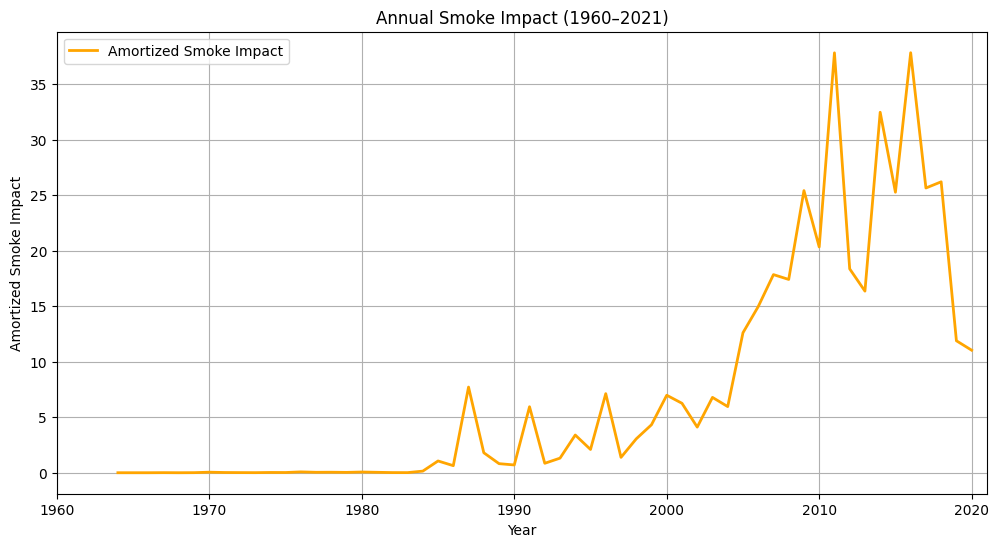

In [11]:
# Create a line plot for scaled smoke impact values from 1960 to 2021
plt.figure(figsize=(12, 6))
plt.plot(yearly_smoke_impact_df['fire_year'], yearly_smoke_impact_df['total_amortized_smoke_impact'], color='orange', linewidth=2, label='Amortized Smoke Impact')

# Customize plot
plt.title('Annual Smoke Impact (1960–2021)')
plt.xlabel('Year')
plt.ylabel('Amortized Smoke Impact')
plt.xlim(1960, 2021)  # Set x-axis limits
plt.legend()
plt.grid(True)

# Show plot
plt.show()


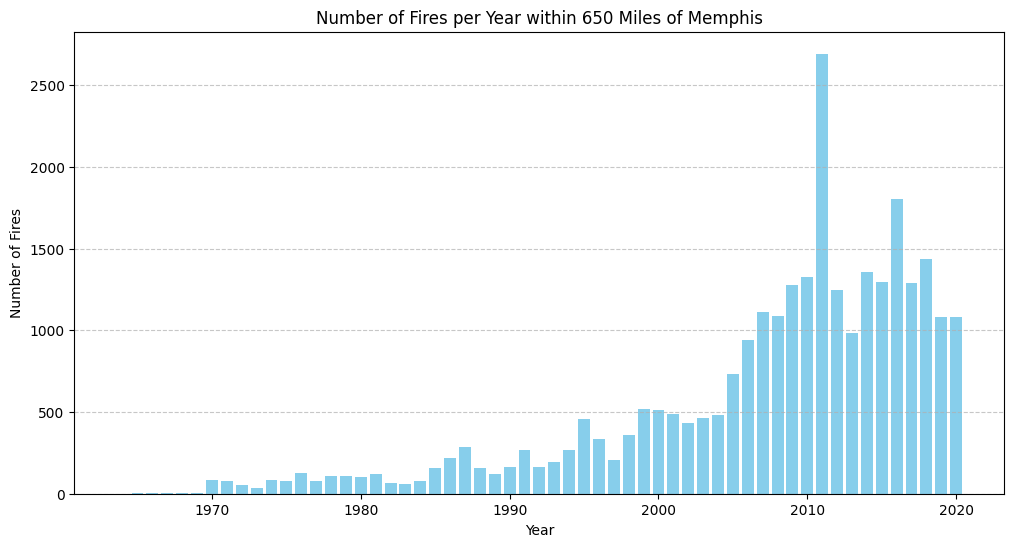

In [12]:
# Calculate the number of fires per year within the 650-mile radius of Memphis
fires_per_year_df = filtered_fire_df.groupby('Fire_Year').size().reset_index(name='num_fires')

# Rename column for consistency
fires_per_year_df = fires_per_year_df.rename(columns={'Fire_Year': 'fire_year'})

# Plot the number of fires per year
plt.figure(figsize=(12, 6))
plt.bar(fires_per_year_df['fire_year'], fires_per_year_df['num_fires'], color='skyblue')
plt.title('Number of Fires per Year within 650 Miles of Memphis')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()
